In [1]:
import numpy as np
import intracluster_smote
import evaluation
import matplotlib.pyplot as plt
%matplotlib inline
import mnist_utils
import pandas as pd
from IPython.display import display
import seaborn as sns
import sklearn
import sklearn.cluster
import traceback

# Clustering Algorithms
These algorithms are used to cluster the dataset. Their output will later serve as input to Intracluster SMOTE to generate artificial data.

In [2]:
def kmeans(X,k):
#     if X.shape[0] < 5000: # 10000 recommended
#         return sklearn.cluster.KMeans(n_clusters=k).fit(X).labels_
#     else:
    return sklearn.cluster.MiniBatchKMeans(n_clusters=k).fit(X).labels_

In [3]:
# Define Clustering on Autoencoder Encoding
from keras.callbacks import TensorBoard
# Fixup for keras for Tensorboard > 0.12
import tensorflow as tf
tf.merge_all_summaries = tf.summary.merge_all
tf.train.SummaryWriter = tf.summary.FileWriter
import time
import autoencoder_keras
def autoencoder_kmeans(X,k): 
    ae = autoencoder_keras.Autoencoder(
        layers=[X.shape[1],128,64,32,64,128,X.shape[1]], 
        training_set=X
    )
    ae.fit(train, train,
            nb_epoch=100,
            batch_size=256,
            shuffle=True,
            verbose=0,
            callbacks=[TensorBoard(log_dir=('./log/{0}'.format(time.asctime().replace(":","h",1).replace(":","m",1))))]
    )
    H = ae.encode(X)
    return (H, kmeans(H,k), ae.decode)

Using TensorFlow backend.


In [4]:
# Define Autoencoder Clustering
import autoencoder
def autoencoder_clustering(X,k): 
    # Pretrain using Keras AE
    ae = autoencoder_keras.Autoencoder(
        layers=[X.shape[1],128,64,32,64,128,X.shape[1]], 
        training_set=X
    )
    ae.fit(train, train,
            nb_epoch=100,
            batch_size=256,
            shuffle=True,
            verbose=0,
            callbacks=[TensorBoard(log_dir=('./log/{0}'.format(time.asctime().replace(":","h",1).replace(":","m",1))))]
    )
    # Cluster with clustering AE
    clustering_ae = autoencoder.Autoencoder(
        layers=[X.shape[1],128,64,32,64,128,X.shape[1]], 
        training_set=X
    )
    clustering_ae.set_parameters(ae.get_weights())
    clustering_ae.cluster(epochs=50, eta=0.01, q=0.01, k=k, minibatch_size=256, mu=0.7)
    H = clustering_ae.encode(X)
    return (H, clustering_ae.get_cluster_assignment(X), clustering_ae.decode)

In [5]:
# each of these returns a tuple of (clustering_function, decoder)
preprocessing_methods = {
    'No Oversampling': (lambda X, k: (X, None, None)),
    'No Clustering (=SMOTE)': (lambda X, k: (X, np.zeros(X.shape[0],), None)),
    'Random Clustering': (lambda X, k: (X, np.random.choice(k, size=(X.shape[0])), None)),
    'K-Means': (lambda X, k: (X, kmeans(X,k), None)),
    'K-Means on Autoencoder Encoding': autoencoder_kmeans,
    'Autoencoder Clustering': autoencoder_clustering
}

# Datasets
Import some datasets to use to test the various data generation methods.

In [6]:
# Import Ecoli Dataset
ecoli_data_raw = pd.read_csv('datasets/ecoli.data.txt', delim_whitespace=True, header=None, names=['Sequence Name','mcg','gvh','lip','chg','aac','alm1','alm2','class'])
ecoli_data_target = ecoli_data_raw['class'].as_matrix()
ecoli_data = ecoli_data_raw.drop(['Sequence Name','class'], axis=1).as_matrix()
ecoli_scaler = sklearn.preprocessing.MinMaxScaler()
ecoli_data = ecoli_scaler.fit_transform(ecoli_data)
ecoli_train, ecoli_validate, ecoli_train_target, ecoli_validate_target = sklearn.model_selection.train_test_split(ecoli_data, ecoli_data_target)

In [7]:
datasets = {
    'MNIST Imbalanced 7+8': {
        'Data': mnist_utils.load_binary_imbalanced(classes=[7,8], ratio=0.2),
        'Imbalance Ratio': 1/5,
        'Minority Class': 8,
        'Scaler': sklearn.preprocessing.MinMaxScaler().fit([[0],[255]]),
        'Plotter': mnist_utils.plot_mnist
    },
    'MNIST Imbalanced 1+7': {
        'Data': mnist_utils.load_binary_imbalanced(classes=[1,7], ratio=0.2),
        'Imbalance Ratio': 1/5,
        'Minority Class': 7,
        'Scaler': sklearn.preprocessing.MinMaxScaler().fit([[0],[255]]),
        'Plotter': mnist_utils.plot_mnist
    },
    'Ecoli': {
        'Data': ((ecoli_train, ecoli_train_target),(ecoli_validate, ecoli_validate_target)),
        'Imbalance Ratio': 1/5.46,
        'Minority Class':'pp',
        'Scaler': ecoli_scaler,
        'Plotter': None
    }
}
for name, dataset in datasets.items():
    dataset['Minority Count'] = np.count_nonzero(dataset['Data'][0][1]==dataset['Minority Class'])
    dataset['Majority Count'] = dataset['Data'][0][0].shape[0]-dataset['Minority Count']
    dataset['Count'] = dataset['Data'][0][0].shape[0]

# Classifiers
These classifiers need no parameter configuration and lend themselves to benchmarking the effectiveness of data generation methods.

In [8]:
classifiers = {
    'Logistic Regression': sklearn.linear_model.LogisticRegression(),
    'Random Forest': sklearn.ensemble.GradientBoostingClassifier(),
    'Gradient Boosting': sklearn.ensemble.RandomForestClassifier(),
    'Support Vector': sklearn.svm.SVC()
}

# Bringing it all together
Loop through all the datasets and evaluate the performance of the different data balancing techniques using all above classifiers.


-----------------------
Dataset: Ecoli

Preprocessing Method: K-Means

Preprocessing Method: Autoencoder Clustering
Starting training with initial training cost: 0.5110581420394112 and validation cost: 0.5110581420394112
Training Time: 74.94234681129456 Per Epoch ~ 1.4988469362258912

Preprocessing Method: No Oversampling

Preprocessing Method: No Clustering (=SMOTE)


C:\Users\D059331\.babun\cygwin\home\D059331\development\data\autoencoder\intracluster_smote.py:42: UserWarning: No minority clusters found. Performing regular SMOTE. Try increasing the number of clusters. Recommended number of clusters: 35 to 217.
  warnings.warn(warning_msg)



Preprocessing Method: K-Means on Autoencoder Encoding

Preprocessing Method: Random Clustering

-----------------------
Dataset: MNIST Imbalanced 1+7

Preprocessing Method: K-Means


C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1381: RuntimeWarning: init_size=300 should be larger than k=3146. Setting it to 3*k
  init_size=init_size)


Plotting MNIST Imbalanced 1+7 synthetic samples after applying K-Means


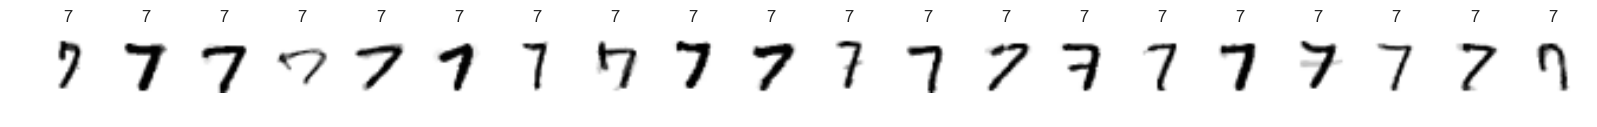

Showing examples of inputs and resulting synthetic samples for K-Means (Parent A, Offspring, Parent B)


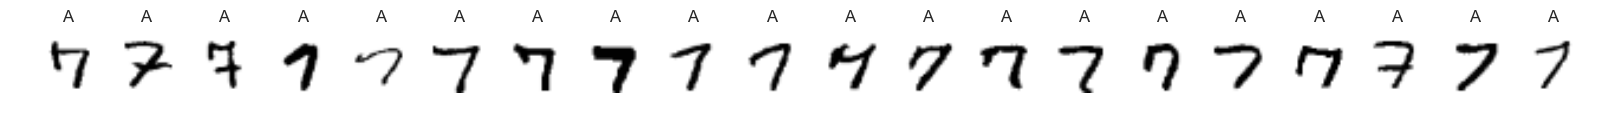

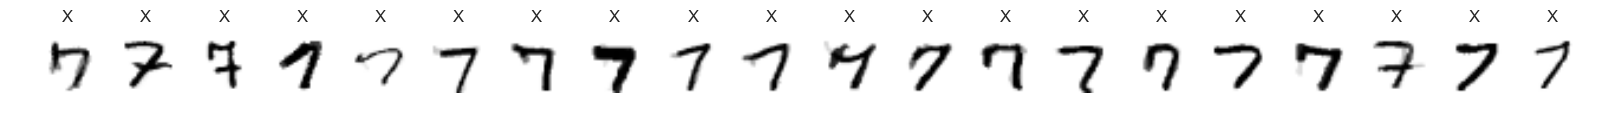

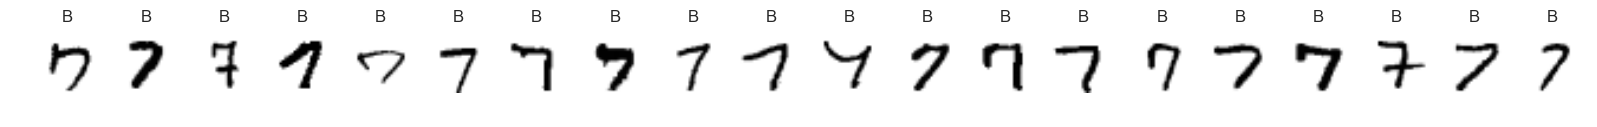


Preprocessing Method: Autoencoder Clustering
Starting training with initial training cost: 0.1352361316920543 and validation cost: 0.1352361316920543
Validation set performance has been unchanged or decreasing for 15 epochs. Stopping training.
Training Time: 1683.6457827091217 Per Epoch ~ 33.67291565418243
Reconstruction Quality Sample of Autoencoder Clustering


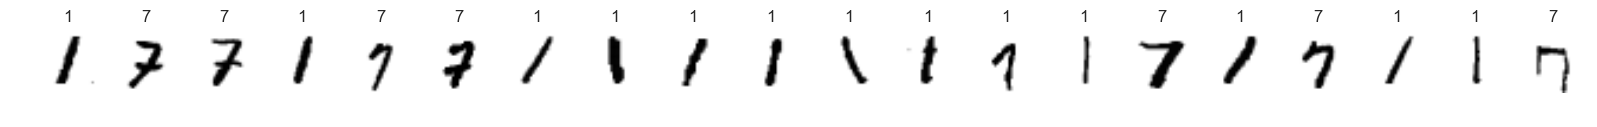

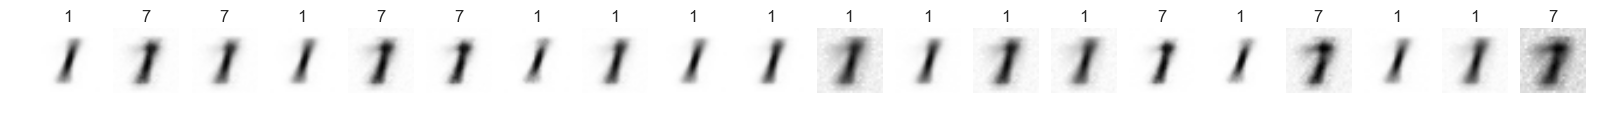

Plotting MNIST Imbalanced 1+7 synthetic samples after applying Autoencoder Clustering


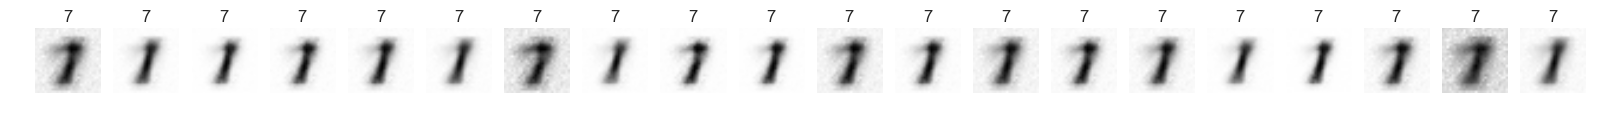

Showing examples of inputs and resulting synthetic samples for Autoencoder Clustering (Parent A, Offspring, Parent B)


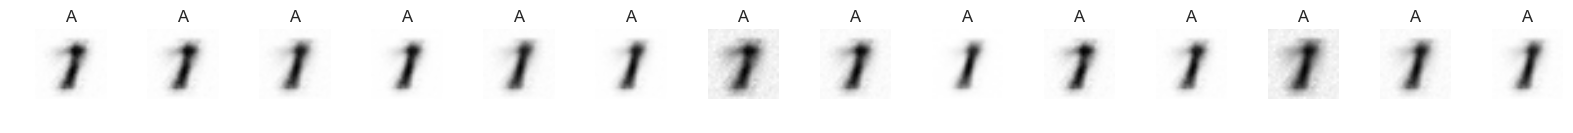

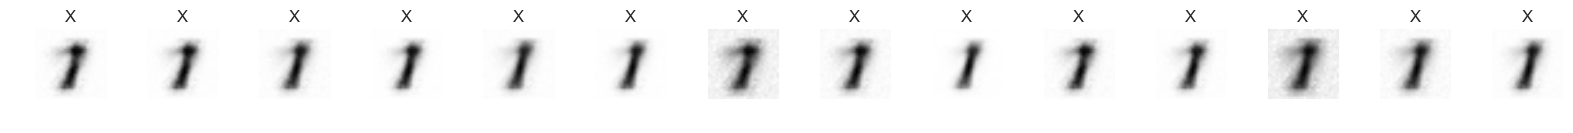

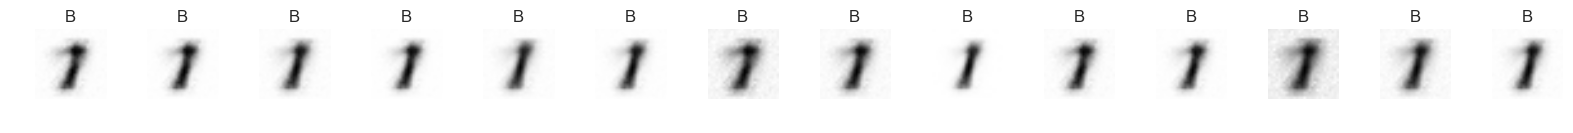


Preprocessing Method: No Oversampling

Preprocessing Method: No Clustering (=SMOTE)


C:\Users\D059331\.babun\cygwin\home\D059331\development\data\autoencoder\intracluster_smote.py:42: UserWarning: No minority clusters found. Performing regular SMOTE. Try increasing the number of clusters. Recommended number of clusters: 1348 to 6742.
  warnings.warn(warning_msg)


Plotting MNIST Imbalanced 1+7 synthetic samples after applying No Clustering (=SMOTE)


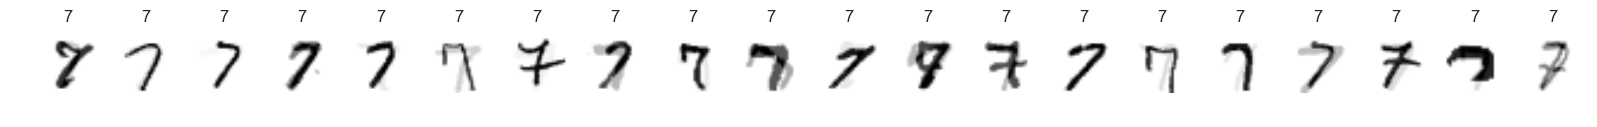

Showing examples of inputs and resulting synthetic samples for No Clustering (=SMOTE) (Parent A, Offspring, Parent B)


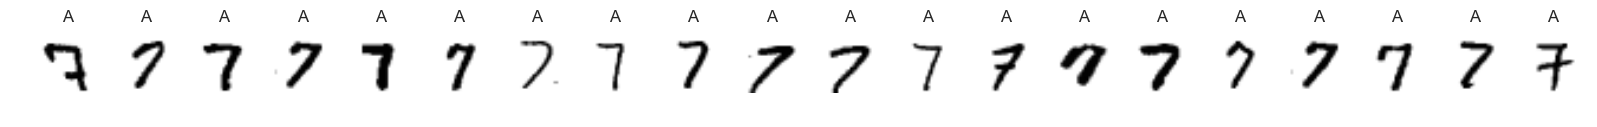

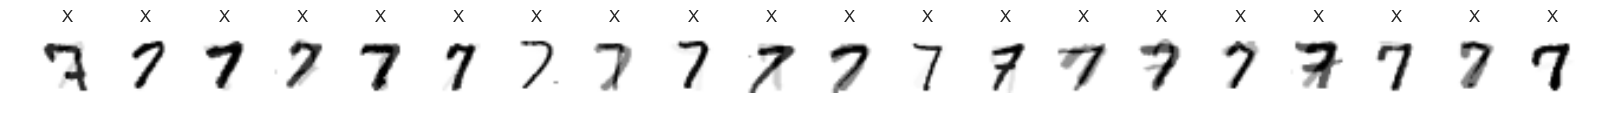

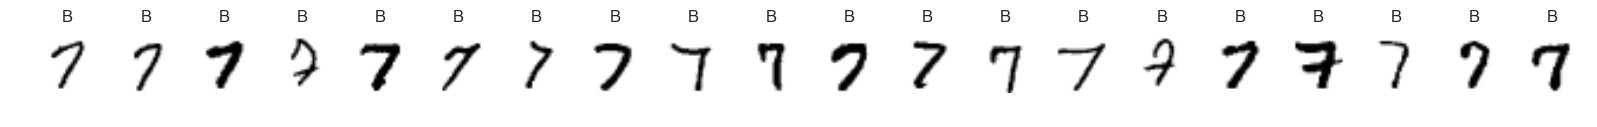


Preprocessing Method: K-Means on Autoencoder Encoding


C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1381: RuntimeWarning: init_size=300 should be larger than k=3146. Setting it to 3*k
  init_size=init_size)


Exception occured at K-Means on Autoencoder Encoding


Traceback (most recent call last):
  File "<ipython-input-9-653e6e6ca45c>", line 15, in <module>
    train_encoded, cluster_labels, decoder = preprocessing_method(train, k)
  File "<ipython-input-3-181a3b30282a>", line 22, in autoencoder_kmeans
    return (H, kmeans(H,k), ae.decode)
  File "<ipython-input-2-56e323ce542b>", line 5, in kmeans
    return sklearn.cluster.MiniBatchKMeans(n_clusters=k).fit(X).labels_
  File "C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py", line 1381, in fit
    init_size=init_size)
  File "C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py", line 681, in _init_centroids
    x_squared_norms=x_squared_norms)
  File "C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py", line 114, in _k_init
    X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True)
IndexError: index 9438 is out of bounds for axis 0 with size 94


Preprocessing Method: Random Clustering
Plotting MNIST Imbalanced 1+7 synthetic samples after applying Random Clustering


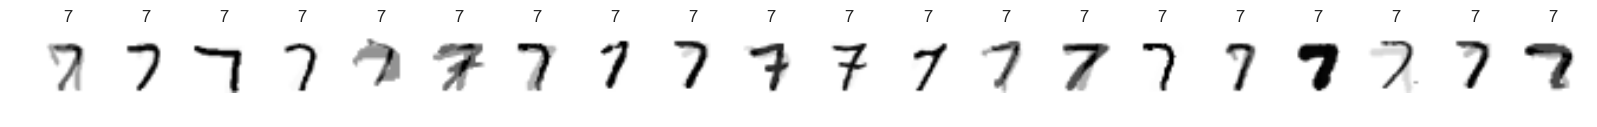

Showing examples of inputs and resulting synthetic samples for Random Clustering (Parent A, Offspring, Parent B)


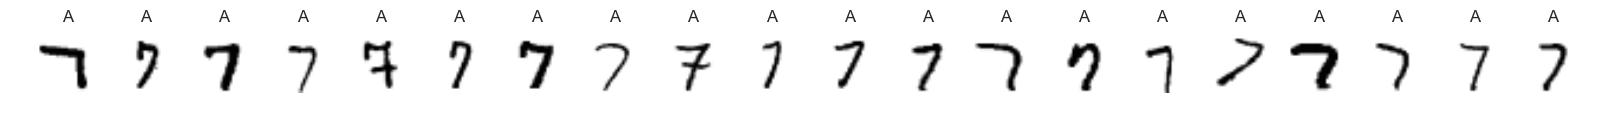

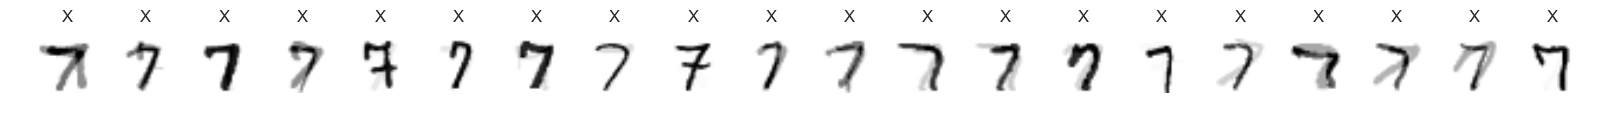

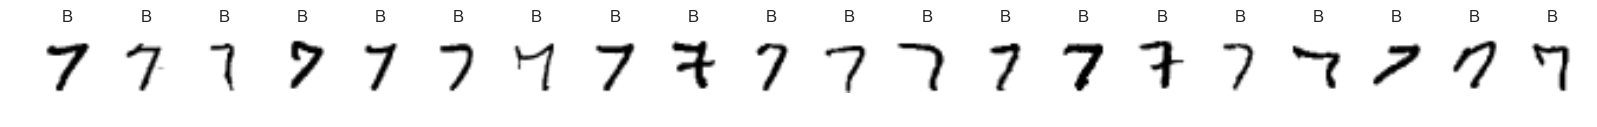


-----------------------
Dataset: MNIST Imbalanced 7+8

Preprocessing Method: K-Means


C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1381: RuntimeWarning: init_size=300 should be larger than k=2923. Setting it to 3*k
  init_size=init_size)


Plotting MNIST Imbalanced 7+8 synthetic samples after applying K-Means


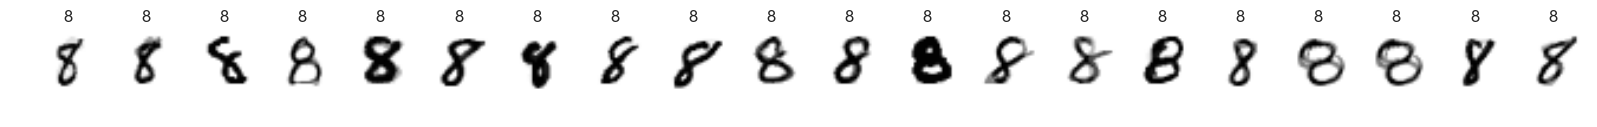

Showing examples of inputs and resulting synthetic samples for K-Means (Parent A, Offspring, Parent B)


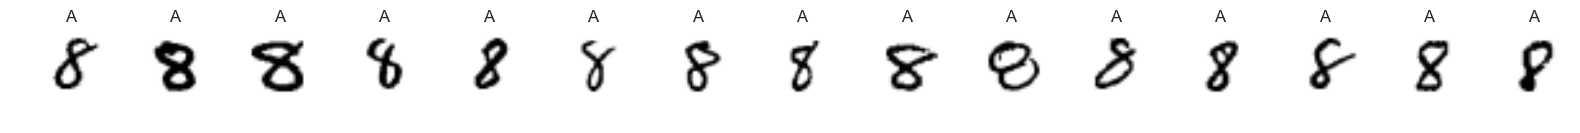

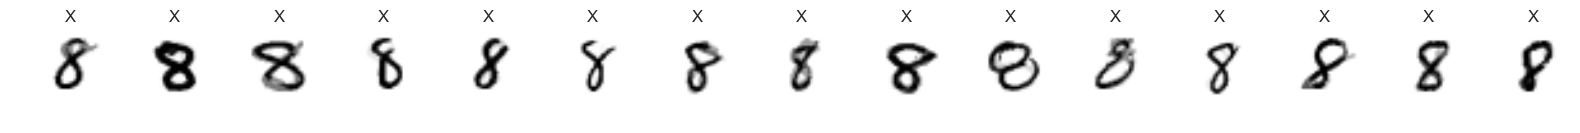

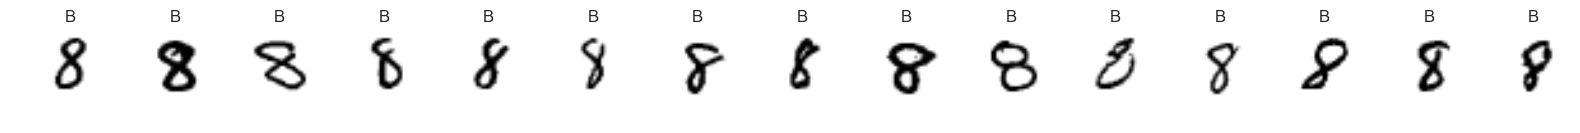


Preprocessing Method: Autoencoder Clustering
Starting training with initial training cost: 0.22450810586144557 and validation cost: 0.22450810586144557
Training Time: 1607.7611107826233 Per Epoch ~ 32.155222215652465
Reconstruction Quality Sample of Autoencoder Clustering


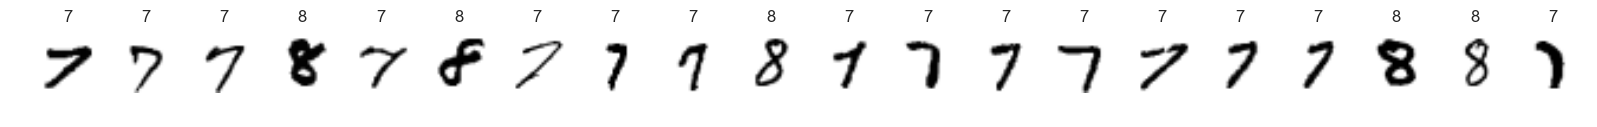

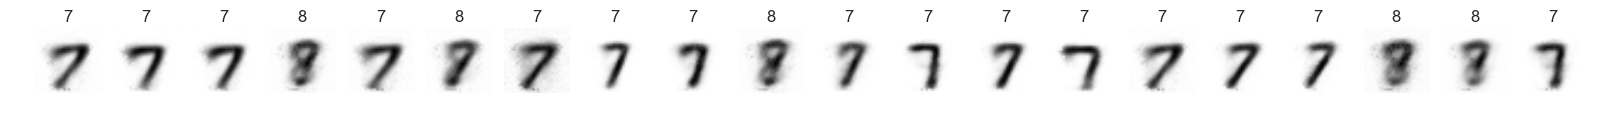

Plotting MNIST Imbalanced 7+8 synthetic samples after applying Autoencoder Clustering


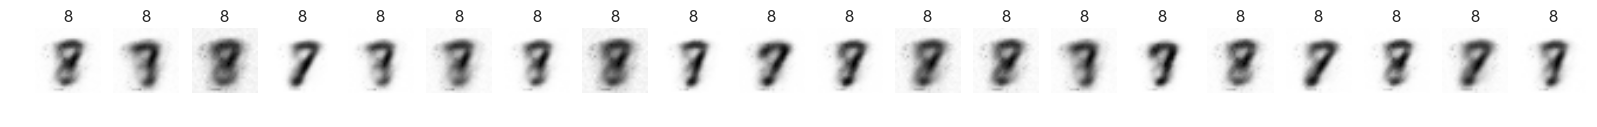

Showing examples of inputs and resulting synthetic samples for Autoencoder Clustering (Parent A, Offspring, Parent B)


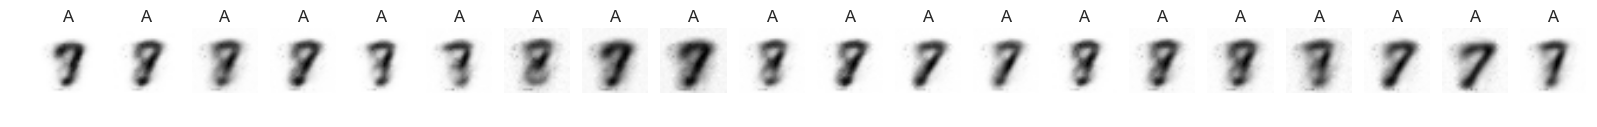

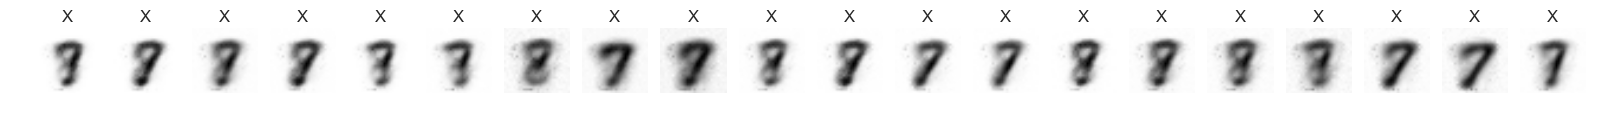

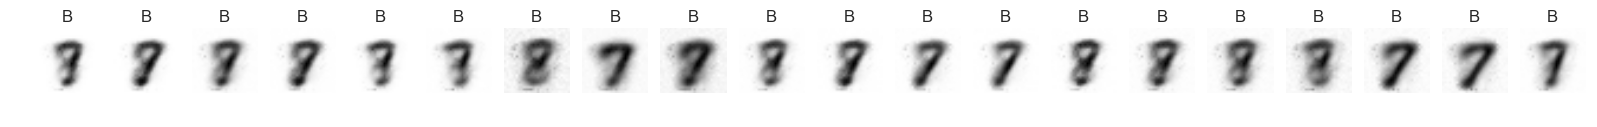


Preprocessing Method: No Oversampling

Preprocessing Method: No Clustering (=SMOTE)


C:\Users\D059331\.babun\cygwin\home\D059331\development\data\autoencoder\intracluster_smote.py:42: UserWarning: No minority clusters found. Performing regular SMOTE. Try increasing the number of clusters. Recommended number of clusters: 1253 to 6265.
  warnings.warn(warning_msg)


Plotting MNIST Imbalanced 7+8 synthetic samples after applying No Clustering (=SMOTE)


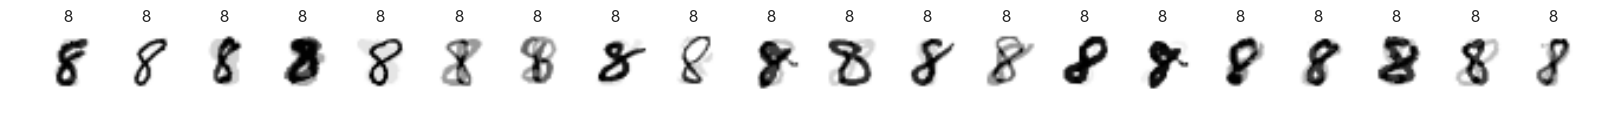

Showing examples of inputs and resulting synthetic samples for No Clustering (=SMOTE) (Parent A, Offspring, Parent B)


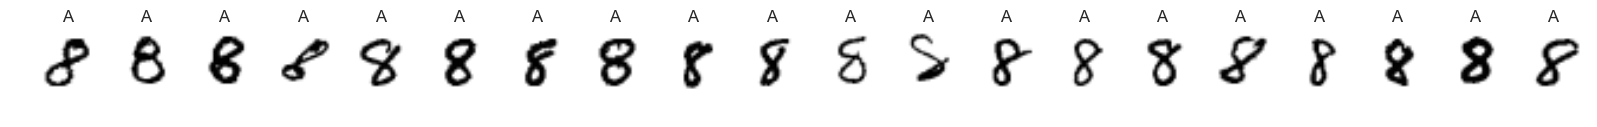

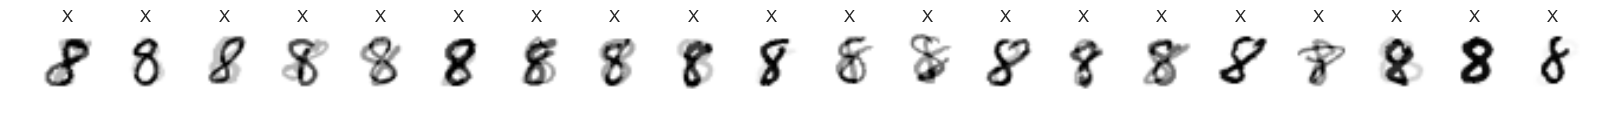

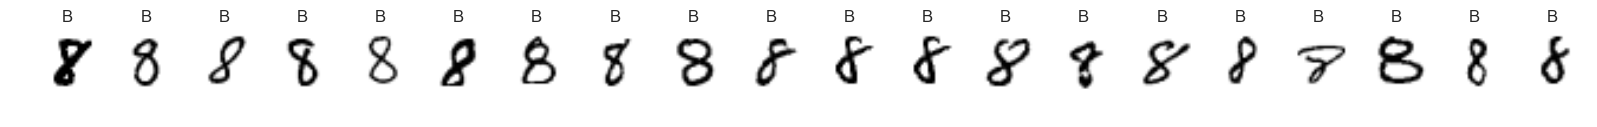


Preprocessing Method: K-Means on Autoencoder Encoding


C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1381: RuntimeWarning: init_size=300 should be larger than k=2923. Setting it to 3*k
  init_size=init_size)


Reconstruction Quality Sample of K-Means on Autoencoder Encoding


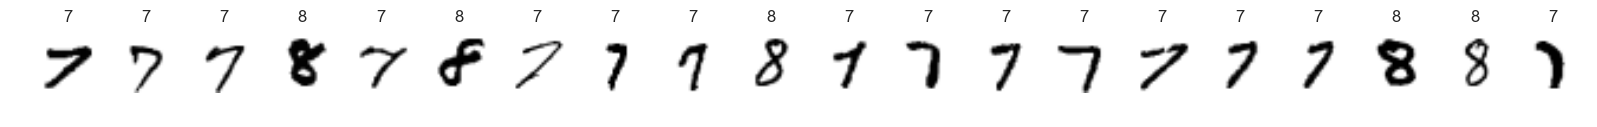

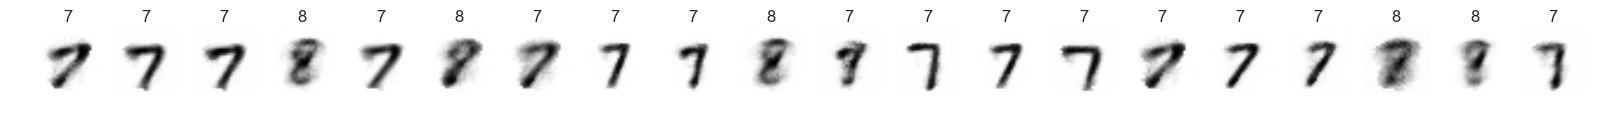

Plotting MNIST Imbalanced 7+8 synthetic samples after applying K-Means on Autoencoder Encoding


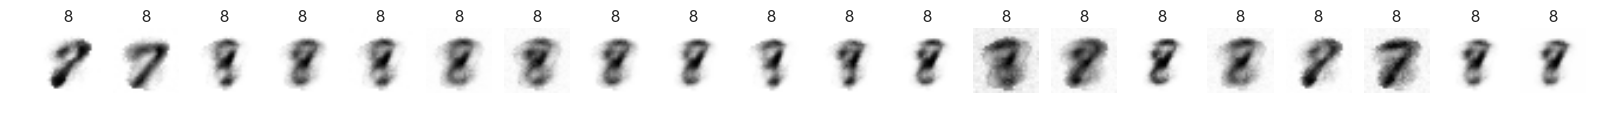

Showing examples of inputs and resulting synthetic samples for K-Means on Autoencoder Encoding (Parent A, Offspring, Parent B)


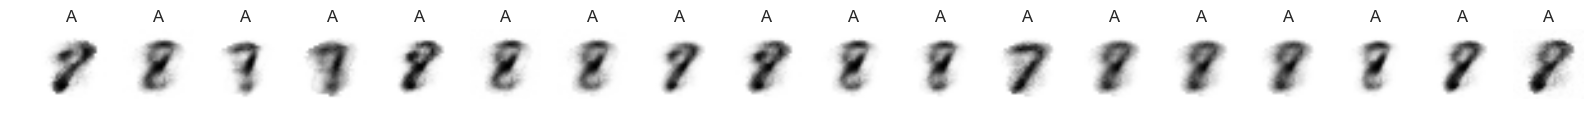

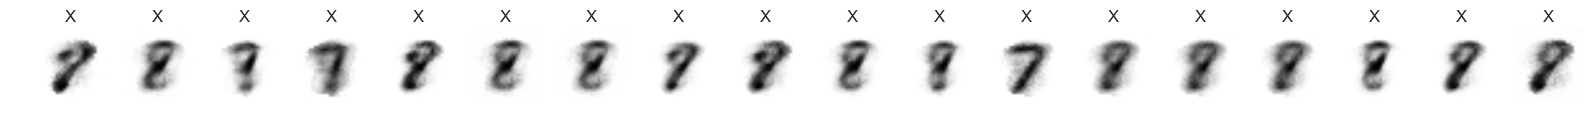

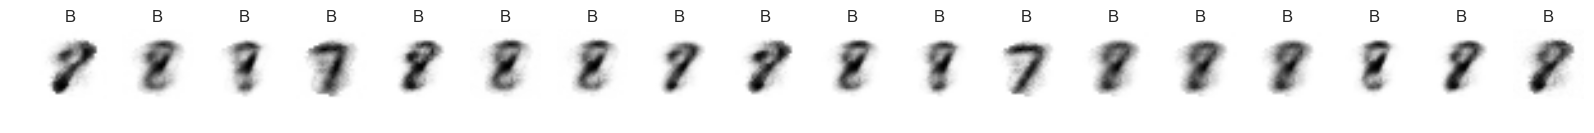


Preprocessing Method: Random Clustering
Plotting MNIST Imbalanced 7+8 synthetic samples after applying Random Clustering


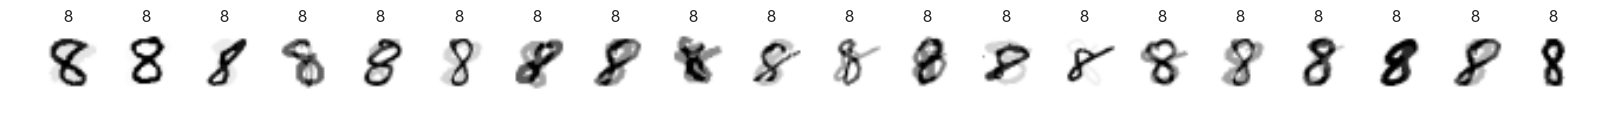

Showing examples of inputs and resulting synthetic samples for Random Clustering (Parent A, Offspring, Parent B)


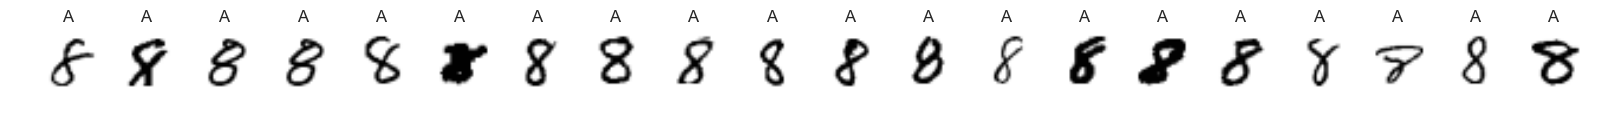

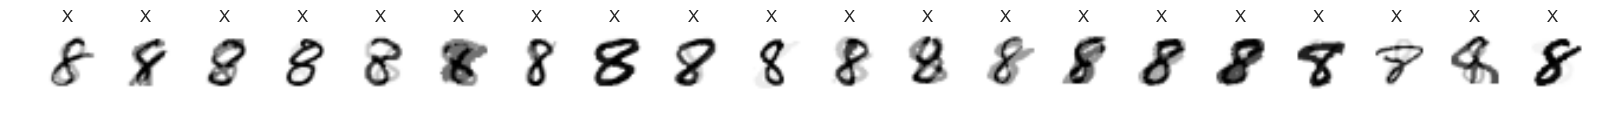

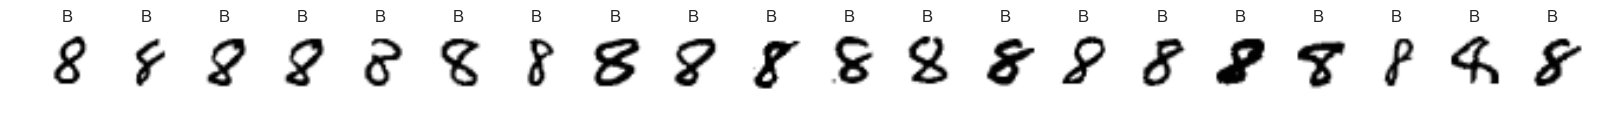

Balanced F-Measure  \
Dataset              Oversampling                    Classifier                                
Ecoli                Autoencoder Clustering          Gradient Boosting              0.323662   
                                                     Logistic Regression            0.057239   
                                                     Random Forest                  0.182498   
                                                     Support Vector                 0.056106   
                     K-Means                         Gradient Boosting              0.644454   
                                                     Logistic Regression            0.519271   
                                                     Random Forest                  0.666066   
                                                     Support Vector                 0.373599   
                     K-Means on Autoencoder Encoding Gradient Boosting              0.233379   
                                                     Logistic Regression            0.068240   
                                                     Random Forest                  0.222194   
                                                     Support Vector                 0.056106   
                     No Clustering (=SMOTE)          Gradient Boosting              0.457076   
                                                     Logistic Regression            0.509956   
                                                     Random Forest                  0.787879   
                                                     Support Vector                 0.373907   
                     No Oversampling                 Gradient Boosting              0.789916   
                                                     Logistic Regression            0.624218   
                                                     Random Forest                  0.681747   
                                                     Support Vector                 0.394154   
                     Random Clustering               Gradient Boosting              0.755387   
                                                     Logistic Regression            0.532207   
                                                     Random Forest                  0.773970   
                                                     Support Vector                 0.379125   
MNIST Imbalanced 1+7 Autoencoder Clustering          Gradient Boosting              0.809741   
                                                     Logistic Regression            0.750831   
                                                     Random Forest                  0.713392   
                                                     Support Vector                 0.876675   
                     K-Means                         Gradient Boosting              0.990633   
                                                     Logistic Regression            0.991985   
...                                                                                      ...   
                     No Oversampling                 Random Forest                  0.991985   
                                                     Support Vector                 0.986546   
                     Random Clustering               Gradient Boosting              0.989275   
                                                     Logistic Regression            0.992014   
                                                     Random Forest                  0.991985   
                                                     Support Vector                 0.993333   
MNIST Imbalanced 7+8 Autoencoder Clustering          Gradient Boosting              0.644484   
                                                     Logistic Regression            0.825346   
                                                     Random Forest                  0.654553   
                                          

In [9]:
classification_evaulation = {}
for dataset_name, dataset in datasets.items():
    print('\n-----------------------')
    print('Dataset:',dataset_name)
    #     if dataset_name != 'Ecoli':continue
    (train, train_target), (test, test_target) = dataset['Data']
    for preprocessing_method_name, preprocessing_method in preprocessing_methods.items():        
        print('\nPreprocessing Method:',preprocessing_method_name)
        if preprocessing_method_name == 'No Oversampling':
            (train_oversampled, train_target_oversampled) = train, train_target
        else:
            #oversample
            try:
                k = dataset['Minority Count']+((dataset['Majority Count']-dataset['Minority Count'])//3)
                train_encoded, cluster_labels, decoder = preprocessing_method(train, k)
                required_synthetic_count =  intracluster_smote.compute_synthetic_count(train.shape[0], dataset['Imbalance Ratio'])
                save_creation_examples = (30/dataset['Count']) if dataset['Plotter'] is not None else 0
                oversampler = intracluster_smote.IntraclusterSmote(required_synthetic_count, decoder=decoder, save_creation_examples=save_creation_examples)
                (train_oversampled, train_target_oversampled), (synth_X, synth_y)  = oversampler.fit_transform(train_encoded, train_target, dataset['Minority Class'], cluster_labels)
                if dataset['Plotter'] is not None:
                    plot = dataset['Plotter']
                    
                    if preprocessing_method_name.rfind('Autoencoder') > -1:
                        print('Reconstruction Quality Sample of', preprocessing_method_name)
                        plot(train, train_target, 20)
                        plot(decoder(train_encoded), train_target, 20)
                        
                    print('Plotting', dataset_name, 'synthetic samples after applying', preprocessing_method_name)
                    plot(synth_X, synth_y, 20)
                    
                    print('Showing examples of inputs and resulting synthetic samples for', preprocessing_method_name, '(Parent A, Offspring, Parent B)')
                    parent_A, offspring, parent_B = zip(*oversampler.creation_examples)
                    for name, examples in [('A',parent_A), ('X', offspring), ('B', parent_B)]:
                        examples = np.asarray(examples)
                        if decoder is not None:
                            examples = decoder(examples)
                        plot(examples, [name for _ in examples], 20)
                        
            except Exception as e:
                print('Exception occured at', preprocessing_method_name)
                traceback.print_exc()
        for classifier_name, classifier in classifiers.items():
            # classify
            classifier.fit(train_oversampled,train_target_oversampled)
            prediction = classifier.predict(test)
            #evaluate
            classification_evaulation[(dataset_name,preprocessing_method_name,classifier_name)] = evaluation.evaluate_classification(prediction, test_target)

res = pd.DataFrame(classification_evaulation).transpose()
res.index.names = (['Dataset', 'Oversampling', 'Classifier'])
res.to_csv('results/{0}.csv'.format(time.asctime().replace(":","h",1).replace(":","m",1)))
display(res)

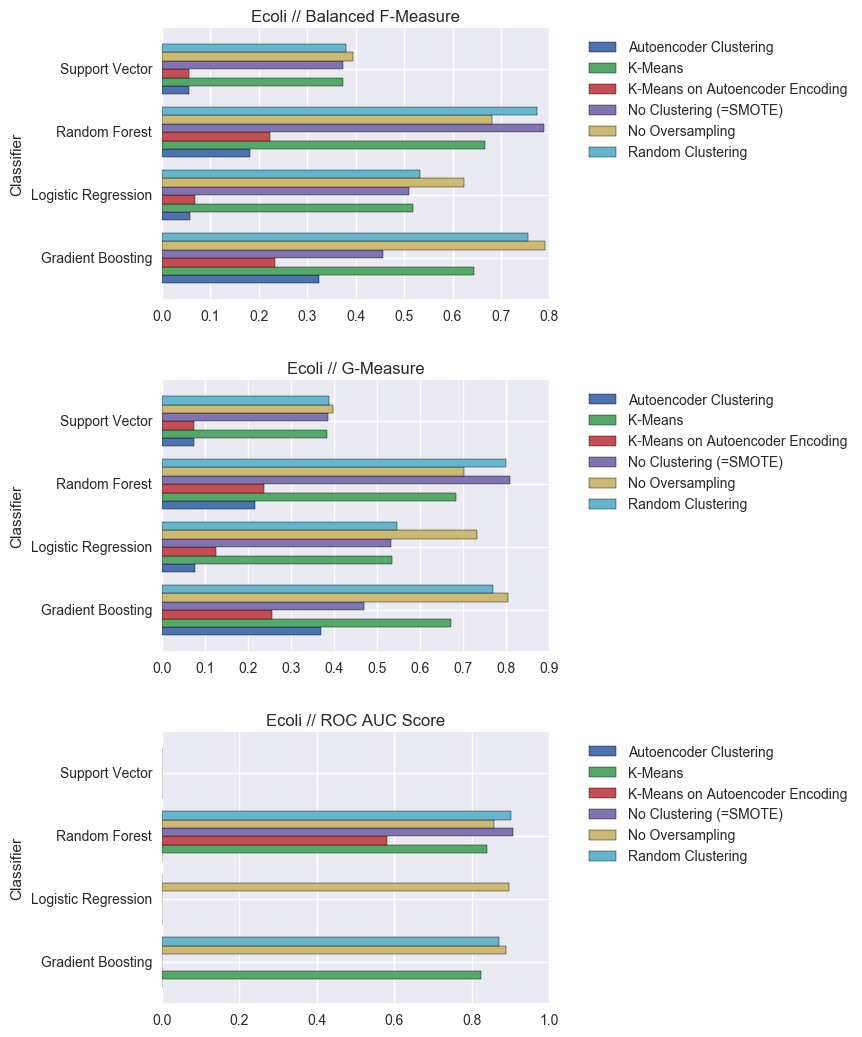

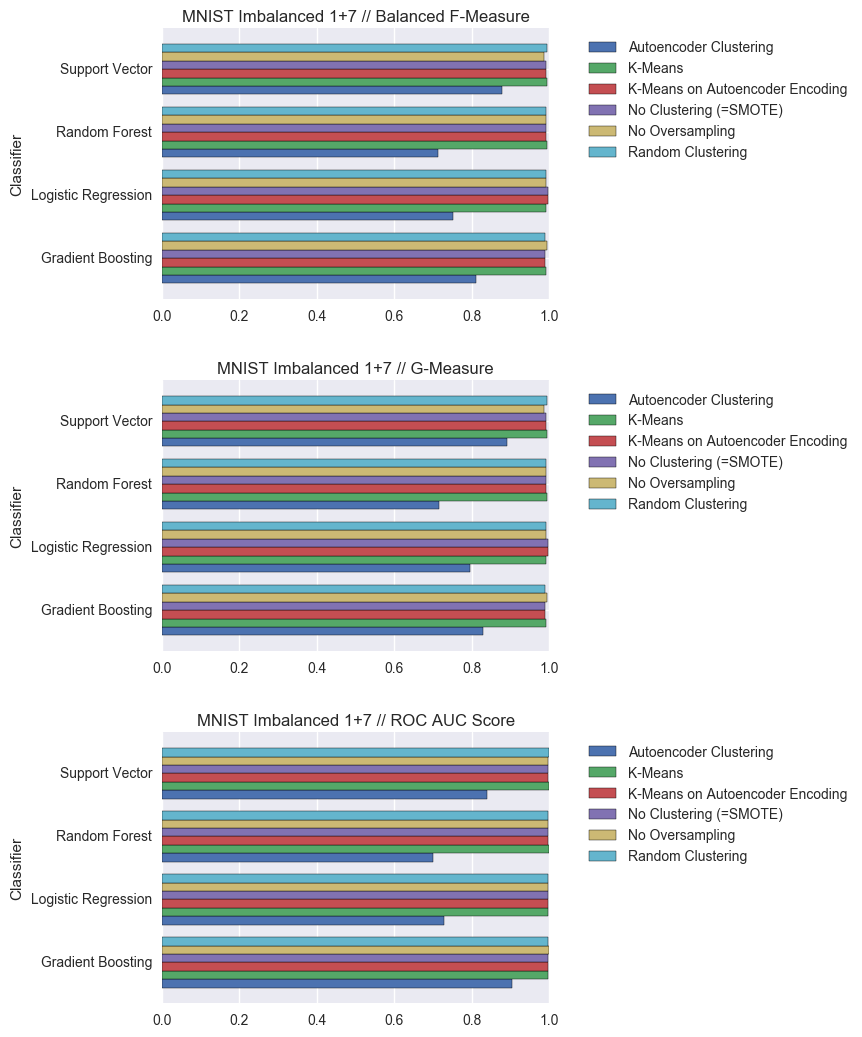

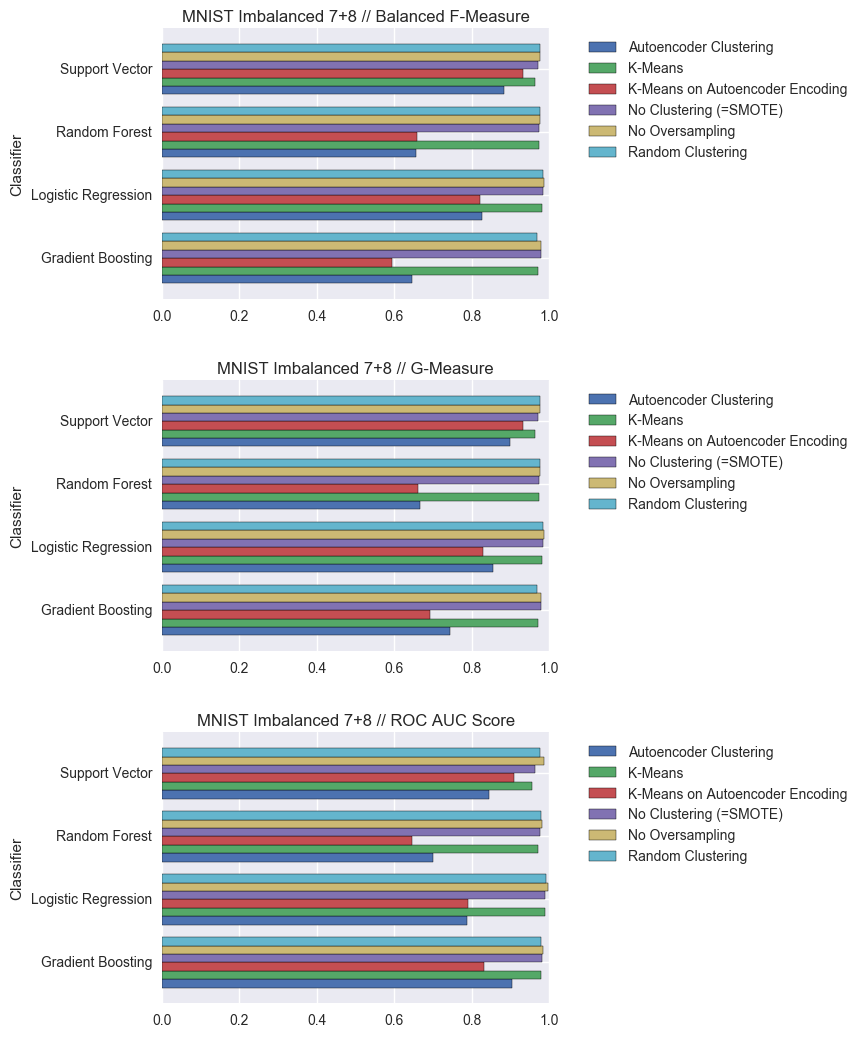

In [10]:
for dataset in res.index.levels[0].values:
    fig, axes = plt.subplots(nrows=len(res.columns), ncols=1)#, subplot_kw={'hspace':2})
    fig.subplots_adjust(top=5, hspace=0.3)
    for i, score in enumerate(res.columns):
        ax=axes[i]
        ax.set_title(dataset + ' // ' + score)
        unstacked_res = res[score][dataset].unstack(level=0)
        unstacked_res.plot(kind='barh',ax=ax, figsize=(5,2), width=.8)
        ax.legend(bbox_to_anchor=(1.8, 1))